In [292]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from scipy.stats import t
from sklearn.preprocessing import StandardScaler
from scipy.integrate import simps
from collections import defaultdict
from matplotlib.animation import FuncAnimation

In [293]:
# Game info - id, week, date, time, teams, scores
games = pd.read_csv("games.csv")


In [294]:
plays = pd.read_csv("plays.csv")
plays['gameClockSeconds'] = pd.to_datetime(plays['gameClock'], format='%M:%S').dt.minute * 60 + pd.to_datetime(plays['gameClock'], format='%M:%S').dt.second
plays.sort_values(by=["gameId", "quarter", "gameClockSeconds"], ascending=[True, True, False], inplace=True)
# plays.head()
# print(plays[["gameId", "gameClockSeconds"]])
plays['penaltyYards'].fillna(0, inplace=True)
plays['passLength'].fillna(0, inplace=True)

plays['passResult'] = plays['passResult'].replace('R', 'Q')
plays['passResult'] = plays['passResult'].fillna('R')
print(plays['passResult'])
print(plays.columns)

4887     C
2817     Q
7698     R
6263     C
3625     R
        ..
11765    R
11617    R
1887     R
9336     R
1575     R
Name: passResult, Length: 12479, dtype: object
Index(['gameId', 'playId', 'ballCarrierId', 'ballCarrierDisplayName',
       'playDescription', 'quarter', 'down', 'yardsToGo', 'possessionTeam',
       'defensiveTeam', 'yardlineSide', 'yardlineNumber', 'gameClock',
       'preSnapHomeScore', 'preSnapVisitorScore', 'passResult', 'passLength',
       'penaltyYards', 'prePenaltyPlayResult', 'playResult',
       'playNullifiedByPenalty', 'absoluteYardlineNumber', 'offenseFormation',
       'defendersInTheBox', 'passProbability', 'preSnapHomeTeamWinProbability',
       'preSnapVisitorTeamWinProbability', 'homeTeamWinProbabilityAdded',
       'visitorTeamWinProbilityAdded', 'expectedPoints', 'expectedPointsAdded',
       'foulName1', 'foulName2', 'foulNFLId1', 'foulNFLId2',
       'gameClockSeconds'],
      dtype='object')


In [295]:
plays.drop("gameClock", axis=1, inplace=True)
plays.head()

,gameId,playId,ballCarrierId,ballCarrierDisplayName,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,...,preSnapVisitorTeamWinProbability,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPoints,expectedPointsAdded,foulName1,foulName2,foulNFLId1,foulNFLId2,gameClockSeconds
4887,2022090800,56,42489,Stefon Diggs,(15:00) (Shotgun) J.Allen pass short right to ...,1,1,10,BUF,LA,...,0.586653,-0.000031,0.000031,1.298699,0.004420,NaN,NaN,NaN,NaN,900
2817,2022090800,80,46076,Josh Allen,"(14:29) (No Huddle, Shotgun) J.Allen scrambles...",1,2,4,BUF,LA,...,0.586684,-0.013497,0.013497,1.303119,0.823571,NaN,NaN,NaN,NaN,869
7698,2022090800,101,47857,Devin Singletary,(13:54) D.Singletary right end to BUF 45 for 7...,1,1,10,BUF,LA,...,0.600181,-0.014850,0.014850,2.126690,0.562363,NaN,NaN,NaN,NaN,834
6263,2022090800,122,47857,Devin Singletary,(13:15) (Shotgun) J.Allen pass short right to ...,1,2,3,BUF,LA,...,0.615031,-0.019032,0.019032,2.689053,0.399209,NaN,NaN,NaN,NaN,795
3625,2022090800,146,47857,Devin Singletary,(12:33) (Shotgun) D.Singletary left tackle to ...,1,1,10,BUF,LA,...,0.634062,0.021616,-0.021616,3.088262,-0.514056,NaN,NaN,NaN,NaN,753


In [296]:
players = pd.read_csv("players.csv")
players['birthDate'] = pd.to_datetime(players['birthDate'])
reference_date = dt(2022, 9, 8)
players['age'] = players['birthDate'].apply(lambda x: reference_date.year - x.year - ((reference_date.month, reference_date.day) < (x.month, x.day)))
players.drop('birthDate', axis = 1, inplace=True)
players.drop('collegeName', axis = 1, inplace=True)
pd.to_numeric(players['nflId'])
players.head()

,nflId,height,weight,position,displayName,age
0,25511,6-4,225,QB,Tom Brady,45.0
1,29550,6-4,328,T,Jason Peters,40.0
2,29851,6-2,225,QB,Aaron Rodgers,38.0
3,30842,6-6,267,TE,Marcedes Lewis,38.0
4,33084,6-4,217,QB,Matt Ryan,37.0


In [297]:
tackles = pd.read_csv("tackles.csv")
missed_tackles = tackles[tackles['pff_missedTackle'] == 1]
tackles = tackles[tackles['pff_missedTackle'] != 1]
tackles.head()

,gameId,playId,nflId,tackle,assist,forcedFumble,pff_missedTackle
0,2022090800,101,42816,1,0,0,0
1,2022090800,393,46232,1,0,0,0
2,2022090800,486,40166,1,0,0,0
3,2022090800,646,47939,1,0,0,0
4,2022090800,818,40107,1,0,0,0


In [298]:
w1 = pd.read_csv("tracking_week_1.csv")
w2 = pd.read_csv("tracking_week_2.csv")
w3 = pd.read_csv("tracking_week_3.csv")
w4 = pd.read_csv("tracking_week_4.csv")
w5 = pd.read_csv("tracking_week_5.csv")
w6 = pd.read_csv("tracking_week_6.csv")
w7 = pd.read_csv("tracking_week_7.csv")
w8 = pd.read_csv("tracking_week_8.csv")
w9 = pd.read_csv("tracking_week_9.csv")

In [299]:
all_weeks = pd.concat([w1, w2, w3, w4, w5, w6, w7, w8, w9])
#normalize all angles on field to how unit circle works
all_weeks['dir'] = all_weeks['dir'].apply(lambda theta : (((360 - theta) + 90) % 360) )
all_weeks['o'] = all_weeks['o'].apply(lambda theta : (((360 - theta) + 90) % 360) )
all_weeks.head()

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event
0,2022090800,56,35472.0,Rodger Saffold,1,2022-09-08 20:24:05.200000,76.0,BUF,left,88.37,27.27,1.62,1.15,0.16,218.26,302.10,NaN
1,2022090800,56,35472.0,Rodger Saffold,2,2022-09-08 20:24:05.299999,76.0,BUF,left,88.47,27.13,1.67,0.61,0.17,219.02,301.47,pass_arrived
2,2022090800,56,35472.0,Rodger Saffold,3,2022-09-08 20:24:05.400000,76.0,BUF,left,88.56,27.01,1.57,0.49,0.15,219.02,302.95,NaN
3,2022090800,56,35472.0,Rodger Saffold,4,2022-09-08 20:24:05.500000,76.0,BUF,left,88.64,26.90,1.44,0.89,0.14,217.62,304.58,NaN
4,2022090800,56,35472.0,Rodger Saffold,5,2022-09-08 20:24:05.599999,76.0,BUF,left,88.72,26.80,1.29,1.24,0.13,216.64,308.05,NaN


In [300]:
plays.drop(columns=['quarter', 'foulName1', 'foulName2', 'foulNFLId1', 'foulNFLId2', 'yardlineSide',
                    'passLength', 'penaltyYards', 'prePenaltyPlayResult', 'playNullifiedByPenalty',
                    'passProbability', 'preSnapHomeTeamWinProbability', 'preSnapVisitorTeamWinProbability', 'homeTeamWinProbabilityAdded',
                    'visitorTeamWinProbilityAdded'], inplace=True)

In [301]:
#calculate distance threshold
# array storing the distance from the tackler to the point of reception/handoff at the moment of play start
all_start_dists = []
# Stores tuple of (playId, gameId, start frame #, defensive team)
play_nums = []
error_counter = 0
for index, play in tackles.iterrows(): 
    current_game_id = play['gameId']
    current_play_id = play['playId']
    #filter to only run plays, filter current_play down to only tackler and ball_carrier to calculate the threshold
    if (plays[(plays['gameId'] == current_game_id) & (plays['playId'] == current_play_id)]['passResult'].values[0] != 'R'):
        continue
    tackler_id = play['nflId']
    ball_carrier_id = plays[(plays["gameId"] == current_game_id) & (plays["playId"] == current_play_id)]['ballCarrierId'].iloc[0]
    current_play = all_weeks[(all_weeks['gameId'] == current_game_id) & (all_weeks['playId'] == current_play_id)]
    current_play = current_play[(current_play["nflId"] == tackler_id) | (current_play["nflId"] == ball_carrier_id) | (current_play["displayName"] == 'football')]
    if ("tackle" not in current_play['event'].unique()):
        continue
    defensive_team = plays[(plays["gameId"] == current_game_id) & (plays["playId"] == current_play_id)]['defensiveTeam'].iloc[0]
    #get moment of handoff = startFrame
    curr_frame = pd.DataFrame()
    min_dist_positions = [-1, -1] # saves the following at moment of reception/handoff: [ball_carrier_x, ball_carrier_y]
    if (current_play['event'] == 'handoff').any():
        curr_frame = current_play[current_play['event'] == 'handoff']
        start_frame = curr_frame['frameId'].iloc[0]
        min_dist_positions[0] = curr_frame[curr_frame['nflId'] == ball_carrier_id]['x'].iloc[0]
        min_dist_positions[1] = curr_frame[curr_frame['nflId'] == ball_carrier_id]['y'].iloc[0]
    
    else:
        min_dist = 100
        start_frame = -1
        for i in range(1,max(current_play['frameId'])):
            curr_frame = current_play[current_play['frameId'] == i]
            ball_carrier_x = curr_frame[curr_frame['nflId'] == ball_carrier_id]['x'].iloc[0]
            ball_carrier_y = curr_frame[curr_frame['nflId'] == ball_carrier_id]['y'].iloc[0]
            football_x = curr_frame[curr_frame['displayName'] == 'football']['x'].iloc[0]
            football_y = curr_frame[curr_frame['displayName'] == 'football']['y'].iloc[0]
            
            dist = math.dist([ball_carrier_x, ball_carrier_y], [football_x, football_y])
            if dist < min_dist:
                min_dist = dist
                min_dist_positions[0] = ball_carrier_x
                min_dist_positions[1] = ball_carrier_y
                start_frame = i
                if dist < .4:
                    break

    curr_frame = current_play[current_play['frameId'] == start_frame]
    curr_frame = curr_frame[curr_frame["nflId"] == tackler_id]
    tackler_x = curr_frame.iloc[0, 9]
    tackler_y = curr_frame.iloc[0, 10]
    tackler_distance = math.dist([min_dist_positions[0], min_dist_positions[1]], [tackler_x, tackler_y])
    b = (current_game_id, current_play_id, start_frame, defensive_team)
    all_start_dists.append(tackler_distance)
    if b not in play_nums:
        play_nums.append(b)

5.600062498882549 9.652761257867734


(array([  7.,  14.,  25.,  29.,  33.,  37.,  67., 142., 271., 388., 612.,
        661., 590., 510., 472., 445., 420., 449., 456., 326., 311., 197.,
        183., 121., 100.,  91.,  65.,  46.,  66.,  64.,  52.,  60.,  64.,
         58.,  75.,  62.,  66.,  49.,  43.,  51.,  40.,  50.,  48.,  31.,
         32.,  38.,  15.,  16.,  19.,  18.,  12.,   8.,  11.,   4.,   7.,
          4.,   3.,   3.,   0.,   1.]),
 array([ 0.30083218,  0.75735517,  1.21387817,  1.67040117,  2.12692416,
         2.58344716,  3.03997015,  3.49649315,  3.95301614,  4.40953914,
         4.86606213,  5.32258513,  5.77910812,  6.23563112,  6.69215411,
         7.14867711,  7.60520011,  8.0617231 ,  8.5182461 ,  8.97476909,
         9.43129209,  9.88781508, 10.34433808, 10.80086107, 11.25738407,
        11.71390706, 12.17043006, 12.62695305, 13.08347605, 13.53999904,
        13.99652204, 14.45304504, 14.90956803, 15.36609103, 15.82261402,
        16.27913702, 16.73566001, 17.19218301, 17.648706  , 18.105229  ,
      

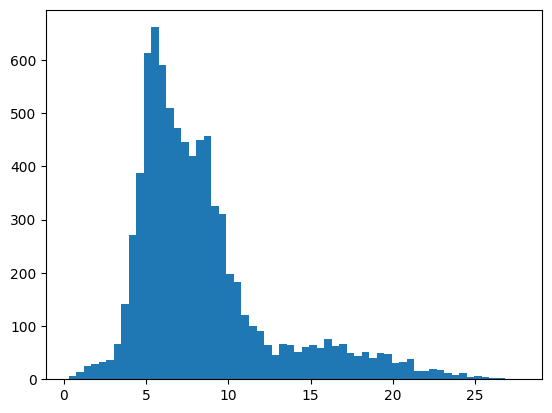

In [303]:
# After running previous cell, all_start_dists has all the distances from ball carrier to tackler at playstart
# for outlier using 1.5IQR + Q3 

all_start_dists = np.array(all_start_dists)
quartile_3 = np.percentile(all_start_dists, 75)
quartile_1 = np.percentile(all_start_dists, 25)

print(quartile_1, quartile_3)
# plt.hist(all_start_dists, bins=50)
potential_tackler_threshold = quartile_3 + 1.5*(quartile_3  - quartile_1)
plt.hist(all_start_dists, bins = 60)

In [304]:
df = all_weeks.merge(plays, on=['gameId', 'playId'], how='inner')

In [305]:
valid = []

def get_name(id):
    return players[players['nflId'] == id]['displayName'].iloc[0]

for game_id, play_id, start_frame, def_club in play_nums:
    #select play
    curr_play = df[(df['gameId'] == game_id) & (df['playId'] == play_id)]
    #select frames
    max_frame = curr_play['frameId'].max()
    end_frame = curr_play[curr_play['event'] == "tackle"]['frameId'].iloc[0] if not curr_play[curr_play['event'] == "tackle"].empty else max_frame
    play_df = curr_play[(curr_play['frameId'] >= start_frame) & (curr_play['frameId'] <= end_frame)]
    # Filtering offensive players
    off_club = play_df[play_df['club'] != def_club]
    #getting start rows for defensive players
    start_frame_rows = play_df[(play_df['club'] == def_club) & (play_df['frameId'] == start_frame)]
    #ball_carrier_name = start_frame_rows['ballCarrierDisplayName'].iloc[0]
    valid_player_names = [player for player in start_frame_rows['displayName'] if 
                          (math.dist([start_frame_rows[start_frame_rows['displayName'] == player]['x'].iloc[0], 
                                      start_frame_rows[start_frame_rows['displayName'] == player]['y'].iloc[0]],
                                     [off_club[off_club['displayName'] == start_frame_rows['ballCarrierDisplayName'].iloc[0]]['x'].iloc[0], 
                                      off_club[off_club['displayName'] == start_frame_rows['ballCarrierDisplayName'].iloc[0]]['y'].iloc[0]])
                          < potential_tackler_threshold)]
    tackler_ids = tackles[(tackles['gameId'] == game_id) & (tackles['playId'] == play_id)]['nflId']
    tackler_names = tackler_ids.apply(get_name).tolist()
    for name in tackler_names:
        if name not in valid_player_names:
            valid_player_names.append(name)
    def_club_filtered = play_df[play_df['displayName'].isin(valid_player_names)]
    valid.extend([off_club, def_club_filtered])

# Concatenate the results outside the loop

In [306]:
# valid_players is a subset of all_weeks and plays
valid_players = pd.concat(valid)

In [ ]:
defensive_positions = ('DE', 'SS', 'FS', 'OLB', 'DT', 'CB', 'MLB')

defensive_players = []
for pos in defensive_positions:
    defensive_players.append(list(players[players['position'] == pos]
                                  .drop(columns=['height', 'weight', 'position', 'displayName', 'age'])['nflId']))

In [ ]:
tackles_to_keep = []

for game_id, play_id, _, __ in play_nums:
    tackle = tackles[(tackles['gameId'] == game_id) & (tackles['playId'] == play_id)]
    tackles_to_keep.append(tackle)

tackles_for_stdev = pd.concat(tackles_to_keep)

tackles_for_stdev = tackles_for_stdev[['gameId', 'playId', 'nflId']]
tackles_for_stdev = tackles_for_stdev.merge(plays[['gameId', 'playId', 'ballCarrierId']], on=['gameId', 'playId'])
weeks_for_stdev = all_weeks[['gameId', 'playId', 'nflId', 'event', 'x', 'y', 'dir', 'playDirection']]
weeks_for_stdev = weeks_for_stdev[weeks_for_stdev['event'].isin(['tackle', 'out_of_bounds', 'fumble', 'qb_slide', 'safety'])]

In [ ]:
defensive_distances_at_tackle = {'DE':([], []), 'SS':([], []), 'FS':([], []), 'OLB':([], []), 'DT':([], []), 'CB':([], []), 'MLB':([], [])}

for index, row in tackles_for_stdev.iterrows():
    game_id = row['gameId']
    play_id = row['playId']
    ball_carrier_id = row['ballCarrierId'] 
    tackler_id = row['nflId']
    
    curr_frame = weeks_for_stdev[(weeks_for_stdev['gameId'] == game_id) & (weeks_for_stdev['playId'] == play_id)]

    x_dist = curr_frame[curr_frame['nflId'] == ball_carrier_id]['x'].iloc[0] - curr_frame[curr_frame['nflId'] == tackler_id]['x'].iloc[0]
    y_dist = curr_frame[curr_frame['nflId'] == ball_carrier_id]['y'].iloc[0] - curr_frame[curr_frame['nflId'] == tackler_id]['y'].iloc[0]
    pos = players[players['nflId'] == tackler_id]['position'].iloc[0]
    
    if curr_frame['playDirection'].iloc[0] == 'right':
        x_dist = x_dist * -1

    theta = np.radians(curr_frame[curr_frame['nflId'] == tackler_id]['dir'].iloc[0])

    # Rotation matrix
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                                [np.sin(theta), np.cos(theta)]])

    # Apply rotation
    rotated_pair = np.dot(rotation_matrix, np.array([x_dist, y_dist]))

    # Extract rotated coordinates
    x_rotated, y_rotated = rotated_pair

    defensive_distances_at_tackle[pos][0].append(x_rotated)
    defensive_distances_at_tackle[pos][1].append(y_rotated)
    


In [ ]:
def remove_outliers(x, y, z_threshold=3):
    # Convert to NumPy arrays
    x_arr, y_arr = np.array(x), np.array(y)

    # Calculate z-scores for distances
    distances = np.sqrt(x_arr**2 + y_arr**2)
    z_scores = np.abs((distances - np.mean(distances)) / np.std(distances))

    # Create a mask based on the z-score threshold
    mask = z_scores < z_threshold

    # Apply the mask to both x and y arrays
    return x_arr[mask], y_arr[mask]

# filtering tackle dist outliers
for index, (x_dists, y_dists) in defensive_distances_at_tackle.items():
    # Remove outliers
    print(index, len(x_dists), len(y_dists))
    filtered_x, filtered_y = remove_outliers(x_dists, y_dists)
    defensive_distances_at_tackle[index] = (filtered_x, filtered_y)


In [ ]:
# Stores (mean, stdev) keyed by position
defensive_stats = {'DE':(0,0), 'SS':(0,0), 'FS':(0,0), 'OLB':(0,0), 'DT':(0,0), 'CB':(0,0), 'MLB':(0,0)}
position_t_info = {
    'DE': [],
    'SS': [],
    'FS': [],
    'OLB': [],
    'DT': [],
    'CB': [],
    'MLB': []
}
# Calculate mean and std for each key
for key, (x_dists, y_dists) in defensive_distances_at_tackle.items():
    mean_x = np.mean(x_dists)
    std_x = np.std(x_dists)
    mean_y = np.mean(y_dists)
    std_y = np.std(y_dists)
    
    defensive_stats[key] = ((mean_x, std_x), (mean_y, std_y))

    ks_statistic_x_norm, p_value_x_norm = stats.kstest(x_dists, 'norm')
    shape_x, loc_x, scale_x = stats.skewnorm.fit(x_dists)
    ks_statistic_x_skew, p_value_x_skew = stats.kstest(x_dists, lambda x: stats.skewnorm.cdf(x, shape_x, loc_x, scale_x))
    df_x_t, loc_x_t, scale_x_t = stats.t.fit(x_dists)
    ks_statistic_x_t, p_value_x_t = stats.kstest(x_dists, 't', args=(df_x_t, loc_x_t, scale_x_t))

    ks_statistic_y_norm, p_value_y_norm = stats.kstest(y_dists, 'norm')
    shape_y, loc_y, scale_y = stats.skewnorm.fit(y_dists)
    ks_statistic_y_skew, p_value_y_skew = stats.kstest(y_dists, lambda x: stats.skewnorm.cdf(x, shape_y, loc_y, scale_y))
    df_y_t, loc_y_t, scale_y_t = stats.t.fit(y_dists)
    ks_statistic_y_t, p_value_y_t = stats.kstest(y_dists, 't', args=(df_y_t, loc_y_t, scale_y_t))
    

    print(key)
    # print(f"KS stat x norm: {ks_statistic_x_norm}")
    # print(f"P-val x norm: {p_value_x_norm}")
    # print(f"KS stat x skew: {ks_statistic_x_skew}")
    print(f"P-val x skew: {p_value_x_skew}")
    # print(f"KS stat x lognorm: {ks_statistic_x_t}")
    print(f"P-val x t: {p_value_x_t}")
    print(df_x_t, loc_x_t, scale_x_t, '\n')
    
    # print(f"KS stat y norm: {ks_statistic_y_norm}")
    # print(f"P-val y norm: {p_value_y_norm}")
    # print(f"KS stat y skew: {ks_statistic_y_skew}")
    print(f"P-val y skew: {p_value_y_skew}")
    # print(f"KS stat y lognorm: {ks_statistic_y_t}")
    print(f"P-val y t: {p_value_y_t}")
    print(df_y_t, loc_y_t, scale_y_t)
    position_t_info[key].append(tuple((df_x_t, loc_x_t, scale_x_t, df_y_t, loc_y_t, scale_y_t)))
    print("------------------------------\n")



In [ ]:
for pos, (x_dists, y_dists) in defensive_distances_at_tackle.items():
    plt.scatter(x_dists, y_dists, color='blue', marker='o', s=10)
    plt.scatter(0, 0, color='red', label='Origin (0, 0)')

    # Set aspect ratio to be equal
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)

    # Add labels and title
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title(f'Tackle Relative to Self for {pos}')

    # Show the plot
    plt.show()


In [ ]:
# Determining velocity drop leading up to 'tackle' event
test_weeks = []
temp_weeks = all_weeks[['s', 'event', 'frameId', 'playId', 'gameId', 'nflId']]

for index, row in tackles.iterrows():
    a = temp_weeks[(temp_weeks['gameId'] == row['gameId']) & (temp_weeks['playId'] == row['playId'])]
    a = a[a['nflId'] == row['nflId']]
    tackle_frame = a[a['event'].isin(['tackle', 'out_of_bounds', 'fumble', 'qb_slide', 'safety'])]['frameId'].iloc[0]
    a = a[(a['frameId'] > tackle_frame - 15) & (a['frameId'] < tackle_frame + 5)]
    a['frameId'] = a['frameId'].apply(lambda x: x - tackle_frame + 15)
    test_weeks.append(a)

test_weeks = pd.concat(test_weeks)

avg_v_df = test_weeks.groupby('frameId')['s'].mean().reset_index()

colors = ['skyblue' if frame_id != 9 else 'orange' for frame_id in avg_v_df['frameId']]

plt.bar(avg_v_df['frameId'], avg_v_df['s'], color=colors)
plt.title('Average s Value by frameId')
plt.xlabel('frameId')
plt.ylabel('Average s Value')
plt.show()


In [ ]:
# for binning by velocity instead of position
tackles_to_keep = []

for game_id, play_id, _, __ in play_nums:
    tackle = tackles[(tackles['gameId'] == game_id) & (tackles['playId'] == play_id)]
    tackles_to_keep.append(tackle)

tackles_for_stdev = pd.concat(tackles_to_keep)

tackles_for_stdev = tackles_for_stdev[['gameId', 'playId', 'nflId']]
tackles_for_stdev = tackles_for_stdev.merge(plays[['gameId', 'playId', 'ballCarrierId']], on=['gameId', 'playId'])
weeks_for_stdev = all_weeks[['gameId', 'playId', 'nflId', 'event', 'x', 'y', 's', 'dir']]
weeks_for_stdev = weeks_for_stdev[weeks_for_stdev['event'].isin(['tackle', 'out_of_bounds', 'fumble', 'qb_slide', 'safety'])]


In [ ]:
distances_by_velocity = [np.array([]), np.array([]), np.array([])] # x dist, y dist, velocity

for index, row in tackles_for_stdev.iterrows():
    game_id = row['gameId']
    play_id = row['playId']
    ball_carrier_id = row['ballCarrierId'] 
    tackler_id = row['nflId']
    
    curr_frame = weeks_for_stdev[(weeks_for_stdev['gameId'] == game_id) & (weeks_for_stdev['playId'] == play_id)]
    speed = curr_frame[curr_frame['nflId'] == tackler_id]['s'].iloc[0]
    
    x_dist = curr_frame[curr_frame['nflId'] == ball_carrier_id]['x'].iloc[0] - curr_frame[curr_frame['nflId'] == tackler_id]['x'].iloc[0]
    y_dist = curr_frame[curr_frame['nflId'] == ball_carrier_id]['y'].iloc[0] - curr_frame[curr_frame['nflId'] == tackler_id]['y'].iloc[0]
    
    theta = np.radians(curr_frame[curr_frame['nflId'] == tackler_id]['dir'].iloc[0])

    # Rotation matrix
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                                [np.sin(theta), np.cos(theta)]])

    # Apply rotation
    rotated_pair = np.dot(rotation_matrix, np.array([x_dist, y_dist]))

    # Extract rotated coordinates
    x_rotated, y_rotated = rotated_pair

    distances_by_velocity[0] = np.append(distances_by_velocity[0], x_rotated)
    distances_by_velocity[1] = np.append(distances_by_velocity[1], y_rotated)
    distances_by_velocity[2] = np.append(distances_by_velocity[2], speed)
    


In [ ]:
# Calculate distance from the origin
distance = np.sqrt(distances_by_velocity[0]**2 + distances_by_velocity[1]**2)

# Calculate z-score for the distance
z_scores = (distance - np.mean(distance)) / np.std(distance)

# Define a threshold for considering values as outliers
z_score_threshold = 3

# Identify indices of outliers
outlier_indices = np.where(np.abs(z_scores) > z_score_threshold)[0]

# Filter out outliers and corresponding velocities
filtered_data = list(
    np.delete(arr, outlier_indices)
    for arr in distances_by_velocity
)

# Unpack the filtered data
filtered_x, filtered_y, filtered_velocities = filtered_data


In [ ]:
sort_indices = np.argsort(filtered_velocities)

# Sort all three arrays using the indices
sorted_x = filtered_x[sort_indices]
sorted_y = filtered_y[sort_indices]
sorted_velocities = filtered_velocities[sort_indices]

combined_array = np.column_stack((sorted_x, sorted_y, sorted_velocities))

# Split the combined array into 50 bins of equal size
bins = np.array_split(combined_array, 50)


In [ ]:
# Initialize an array to store the t-distribution parameters for each bin
t_params = []

# Loop through each bin
for bin_content in bins:
    # Extract x, y from the bin content
    x_data = bin_content[:, 0]
    y_data = bin_content[:, 1]

    # Normalize x_data and y_data
    scaler = StandardScaler()
    x_data_normalized = scaler.fit_transform(x_data.reshape(-1, 1)).flatten()
    y_data_normalized = scaler.fit_transform(y_data.reshape(-1, 1)).flatten()

    # Fit x_data to a t-distribution and get parameters
    x_params = t.fit(x_data_normalized)

    # Fit y_data to a t-distribution and get parameters
    y_params = t.fit(y_data_normalized)

    # Save the parameters in a tuple (degrees of freedom, loc, scale)
    t_params.append((x_params[0], x_params[1], x_params[2], y_params[0], y_params[1], y_params[2]))




In [ ]:
average_velocities = []
for bin in bins:
    avg = 0
    for entry in bin:
        avg += entry[2]
    avg = avg/len(bin)
    average_velocities.append(avg)

# Extract the degrees of freedom and scale parameters for each bin
df_x, loc_x, scale_x, df_y, loc_y, scale_y = zip(*t_params)

df_y = list(df_y)
for i in range(len(df_y)):
    if df_y[i] > 10:
        df_y[i] = 10
df_x = list(df_x)
for i in range(len(df_x)):
    if df_x[i] > 10:
        df_x[i] = 10

# Create a scatter plot
plt.scatter(average_velocities, scale_x, label='X-axis')
plt.scatter(average_velocities, scale_y, label='Y-axis')

plt.title('Standard Deviation vs. Average Velocity for Each Bin')
plt.xlabel('Average Velocity')
plt.ylabel('Standard Deviation')
plt.legend()

plt.show()



In [ ]:
X = sm.add_constant(average_velocities)

model = sm.OLS(scale_x, X)
result = model.fit()

print(result.summary())


In [307]:
def create_football_field(ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6.33))
        ax_created = True
    else:
        ax_created = False
    #Field green
    ax.set_facecolor('green')
    #Yardlines
    for x in range(10, 110, 10):
        line = patches.Rectangle((x, 0), .1, 53.3, linewidth=1, edgecolor='white', facecolor='white')
        ax.add_patch(line)
    #Endzones
    endzone1 = patches.Rectangle((0, 0), 10, 53.3, linewidth=1, edgecolor='white', facecolor='blue')
    endzone2 = patches.Rectangle((110, 0), 10, 53.3, linewidth=1, edgecolor='white', facecolor='blue')
    ax.add_patch(endzone1)
    ax.add_patch(endzone2)

    if ax_created:
        ax.set_xlim(0, 120)
        ax.set_ylim(0, 53.3)
        ax.set_xlabel('Yards (Length of Field)')
        ax.set_ylabel('Yards (Width of Field)')
        ax.set_title('NFL Football Field')

    return ax


In [308]:
position_t_info = {
    "DE" : ((7.322719232987062, 0.12881529495845334, 0.6672880475498693, 6.42785426010332, 0.019966113155859003, 0.6477597816301706)),
    "SS" : ((5.107508394561631, 0.06568784144823583, 0.7446880972538361, 4.569412367147843, -0.012239447953968512, 0.8262114794845226)),
    "FS" : ((4.66532319164847, 0.1351910850714022, 0.6842657927545983, 6.06998121022001, -0.0006546715218879895, 0.7795782785182302)),
    "OLB" :((5.273472395245827, 0.10663288071080984, 0.6205551604648218, 7.334952546776893, 0.026189916367707178, 0.6488302045518881)) , 
    "DT" :((5.569558115334946, 0.07408100340712373, 0.6105034874867465, 6.393630032210144, -0.005045181011060849, 0.6302374841727374)) ,
    "CB" :((6.349296636622419, 0.10235641145240083, 0.892232719512297, 5.448775313396228, 0.015871937817115187, 0.7796017896374858)) ,
    "MLB" :((7.13173972579105, 0.12282249024093272, 0.6228963914601275, 6.9587549714459715, 0.011692059600892205, 0.6577565119449411)) }


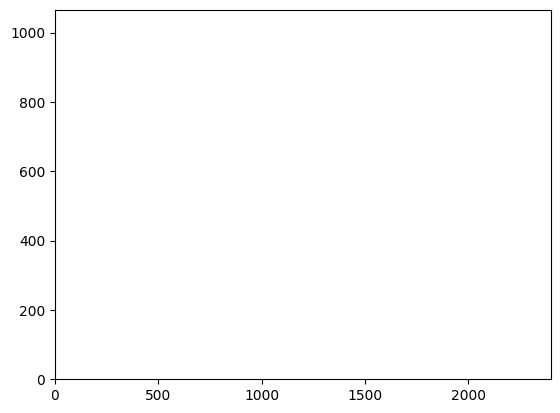

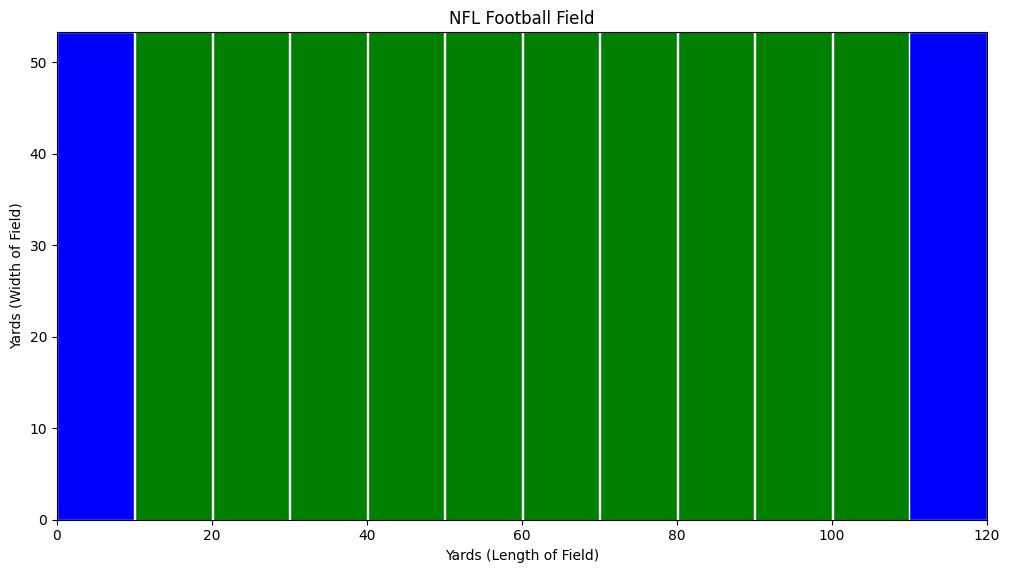

In [309]:
from matplotlib.animation import FuncAnimation
from scipy.stats import t
def get_frame_data(frame_id, game_id, play_id, def_club, off_club):
    curr_play_def = all_weeks[(all_weeks['gameId'] == game_id) & (all_weeks['playId'] == play_id) & (all_weeks['frameId'] == frame_id)
                            & (all_weeks['club'] == def_club)]
    curr_play_off = all_weeks[(all_weeks['gameId'] == game_id) & (all_weeks['playId'] == play_id) & (all_weeks['frameId'] == frame_id)
                                & (all_weeks['club'] == off_club)]
    return curr_play_def, curr_play_off

def init():
    ax = create_football_field()
    return ax,

# Animation function, called for each frame
def animate(frame_id):
    ax.clear()
    create_football_field(ax)
    # Get the data for the current frame
    curr_play_def, curr_play_off = get_frame_data(frame_id, game_id, play_id, def_club, 'DAL')
    offensive_pdf_grid = np.zeros((int(120 * 20), int(53.3 * 20)))

    for playerId in curr_play_off['nflId'].unique():
        player_data = curr_play_off[curr_play_off['nflId'] == playerId]
        player_x, player_y = player_data['x'].iloc[0], player_data['y'].iloc[0]
        if (playerId != ball_carrier_id):

            x_points = np.linspace(player_x - 1.4, player_x + 1.4, 20)
            y_points = np.linspace(player_y - 1.4, player_y + 1.4, 20)
            pdf_x_points = norm.pdf(x_points, loc = player_x, scale = .7)
            pdf_y_points = norm.pdf(y_points, loc = player_y, scale=.7)

            X, Y = np.meshgrid(x_points, y_points)
            joint_pdf = np.outer(pdf_y_points, pdf_x_points)
            for i in range(len(joint_pdf)):
                for j in range(len(joint_pdf[i])):
                    grid_x_index = int(X[i, j] * 20)
                    grid_y_index = int(Y[i, j] * 20)
                    if (0 <= grid_x_index) and (0 <= grid_y_index) and (grid_x_index <= 120 * 20) and (grid_y_index <= 53.3 * 20):
                        offensive_pdf_grid[grid_x_index][grid_y_index] += joint_pdf[i][j]
                    if joint_pdf[i][j] < .05:
                        joint_pdf[i][j] = np.NaN
            
            ax.contourf(X, Y, joint_pdf, cmap="gist_heat", alpha=0.8)
        else:
            ball_carrier = patches.Circle((player_x, player_y), .8, color = '#FC0FC0')
            ax.add_patch(ball_carrier)
    #defensive plotting
    for playerId in curr_play_def['nflId'].unique():

        defender = curr_play_def[curr_play_def['nflId'] == playerId]
        player_x,player_y = defender['x'].iloc[0], defender['y'].iloc[0]
        player_pos = players[players['nflId'] == playerId]['position'].iloc[0]

        #making the distribution
        x_df, x_mu, x_sigma, y_df, y_mu, y_sigma = position_t_info[player_pos]
        t_score_x = t.ppf(0.975, x_df)
        t_score_y = t.ppf(0.975, y_df)
        x,y = player_x + x_mu, player_y + y_mu

        x_points = np.linspace(x - (x_sigma*t_score_x), x + (x_sigma*t_score_x), 20)
        y_points = np.linspace(y - (y_sigma*t_score_y), y + (y_sigma*t_score_y),  20)

        pdf_x_points = t.pdf(x_points, df=x_df, loc=x, scale=x_sigma)
        pdf_y_points = t.pdf(y_points, df=y_df, loc=y, scale=y_sigma) 
        # Creating a meshgrid for the joint distribution
        X, Y = np.meshgrid(x_points, y_points)

        joint_pdf = np.outer(pdf_y_points, pdf_x_points)

        # Plotting the rotated joint PDF
        for i in range(len(joint_pdf)):
            for j in range(len(joint_pdf[i])):
                grid_x_index = int(X[i, j] * 20)
                grid_y_index = int(Y[i, j] * 20)
                joint_pdf[i][j] = (joint_pdf[i][j]**2) / (offensive_pdf_grid[grid_x_index][grid_y_index] +joint_pdf[i][j])
                if joint_pdf[i][j] < .05:
                    joint_pdf[i][j] = np.NaN

        ax.contourf(X, Y, joint_pdf, cmap="viridis", alpha=0.6)

    return ax,

total_frames = 50

# Create the animation
game_id, play_id = 2022102303,1919
start_frame, def_club = 0, 'DET'
play = all_weeks[(all_weeks['gameId'] == game_id) & (all_weeks['playId'] == play_id)]
frames_list = play['frameId'].unique().tolist()
fig, ax = plt.subplots()
ax.set_xlim(0, 120*20)
ax.set_ylim(0, 53.3*20)
anim = FuncAnimation(fig, animate, init_func=init, frames= frames_list, interval=100, blit=False)


plt.show()
anim.save('animation.gif', writer='pillow', fps=10)

In [310]:
print(valid_players.columns)
valid_players.drop(columns=['time','jerseyNumber', 'playDirection', 's', 'a', 'dis', 'o',
       'dir', 'ballCarrierDisplayName',
       'playDescription', 'down', 'yardsToGo', 'possessionTeam',
       'defensiveTeam', 'yardlineNumber', 'preSnapHomeScore',
       'preSnapVisitorScore', 'passResult', 'playResult',
       'absoluteYardlineNumber', 'offenseFormation', 'defendersInTheBox',
       'expectedPoints', 'expectedPointsAdded', 'gameClockSeconds'], inplace = True)
valid_players['x'] = valid_players['x'].apply(lambda x: round(x / 0.02) * 0.02)
valid_players['y'] = valid_players['y'].apply(lambda y: round(y / 0.02) * 0.02)

Index(['gameId', 'playId', 'nflId', 'displayName', 'frameId', 'time',
       'jerseyNumber', 'club', 'playDirection', 'x', 'y', 's', 'a', 'dis', 'o',
       'dir', 'event', 'ballCarrierId', 'ballCarrierDisplayName',
       'playDescription', 'down', 'yardsToGo', 'possessionTeam',
       'defensiveTeam', 'yardlineNumber', 'preSnapHomeScore',
       'preSnapVisitorScore', 'passResult', 'playResult',
       'absoluteYardlineNumber', 'offenseFormation', 'defendersInTheBox',
       'expectedPoints', 'expectedPointsAdded', 'gameClockSeconds'],
      dtype='object')


In [373]:
tackler_metric = defaultdict(list) #nflId -> array of WATT's
max_grid_x = 120 * 25
max_grid_y = int(53.3 * 25)
#populates tackler_metric
for game_id, play_id, start_frame, def_club in play_nums:
    curr_play = valid_players.query('gameId == @game_id and playId == @play_id')
    curr_play_off = curr_play.query('club != @def_club and displayName != "football"')
    curr_play_def = curr_play.query('club == @def_club')

    ball_carrier_id = plays.query('gameId == @game_id and playId == @play_id')['ballCarrierId'].iloc[0]
    curr_play_ballcarrier = curr_play_off.query('nflId == @ball_carrier_id')
    curr_play_off = curr_play_off.query('nflId != @ball_carrier_id')

    offensive_pdf_grid = np.zeros((int(max_grid_x), int(max_grid_y)))
    tackler_ids = tackles.query('gameId == @game_id and playId == @play_id')['nflId'].tolist()
    bum_ids = missed_tackles.query('gameId == @game_id and playId == @play_id')['nflId'].tolist()
    potential_tacklers_dict = defaultdict(list)

    ball_carrier_positions = curr_play_ballcarrier[['frameId', 'x', 'y']].copy()
    ball_carrier_positions['x_on_grid'] = np.trunc(np.round(ball_carrier_positions['x'] / 0.04) * 2) / 2
    ball_carrier_positions['y_on_grid'] = np.trunc(np.round(ball_carrier_positions['y'] / 0.04) * 2) / 2
    ball_carrier_positions.set_index('frameId', inplace=True)

    for frame in curr_play['frameId'].unique():
        if frame not in ball_carrier_positions.index:
            continue

        ball_carrier_x_on_grid = ball_carrier_positions.loc[frame, 'x_on_grid']
        ball_carrier_y_on_grid = ball_carrier_positions.loc[frame, 'y_on_grid']

        for playerId, player_data in curr_play_off[curr_play_off['frameId'] == frame].groupby('nflId'):
            player_x, player_y = player_data[['x', 'y']].iloc[0]
            
            x_points = np.linspace(player_x - 1.4, player_x + 1.4, 25)
            y_points = np.linspace(player_y - 1.4, player_y + 1.4, 25)
            pdf_x_points = norm.pdf(x_points, loc=player_x, scale=0.7)
            pdf_y_points = norm.pdf(y_points, loc=player_y, scale=0.7)

            X, Y = np.meshgrid(x_points, y_points)
            joint_pdf = np.outer(pdf_y_points, pdf_x_points)

            grid_x_index = (X * 25).astype(int)
            grid_y_index = (Y * 25).astype(int)

            valid_positions = (grid_x_index >= 0) & (grid_x_index < max_grid_x) & \
                            (grid_y_index >= 0) & (grid_y_index < max_grid_y)

            flat_grid_x_index = grid_x_index[valid_positions].ravel()
            flat_grid_y_index = grid_y_index[valid_positions].ravel()
            flat_joint_pdf = joint_pdf[valid_positions].ravel()

            np.add.at(offensive_pdf_grid, (flat_grid_x_index, flat_grid_y_index), flat_joint_pdf)

        for playerId in curr_play_def['nflId'].unique():
            defender = curr_play_def[(curr_play_def['nflId'] == playerId) & (curr_play_def['frameId'] == frame)]
            player_x, player_y = defender['x'].iloc[0], defender['y'].iloc[0]
            player_pos = players[players['nflId'] == playerId]['position'].iloc[0]

            x_df, x_mu, x_sigma, y_df, y_mu, y_sigma = position_t_info[player_pos]
            t_score_x = t.ppf(0.975, x_df)
            t_score_y = t.ppf(0.975, y_df)
            x, y = player_x + x_mu, player_y + y_mu

            x_min_rounded = np.trunc(np.round((x - (x_sigma*t_score_x)) / 0.04) * 4) / 100
            x_max_rounded = np.trunc(np.round((x + (x_sigma*t_score_x)) / 0.04) * 4) / 100
            y_min_rounded = np.trunc(np.round((y - (y_sigma*t_score_y)) / 0.04) * 4) / 100
            y_max_rounded = np.trunc(np.round((y + (y_sigma*t_score_y)) / 0.04) * 4) / 100

            x_points = np.linspace(x_min_rounded, x_max_rounded, round(25 * (x_max_rounded - x_min_rounded)) + 1)
            y_points = np.linspace(y_min_rounded, y_max_rounded, round(25 * (y_max_rounded - y_min_rounded)) + 1)
            dx, dy = 0.02, 0.02

            pdf_x_points = t.pdf(x_points, df=x_df, loc=x, scale=x_sigma)
            pdf_y_points = t.pdf(y_points, df=y_df, loc=y, scale=y_sigma)

            X, Y = np.meshgrid(x_points, y_points)
            joint_pdf = np.outer(pdf_y_points, pdf_x_points)

            grid_x = (X * 25).astype(int)
            grid_y = (Y * 25).astype(int)

            valid_positions = (grid_x >= 0) & (grid_x < max_grid_x) & (grid_y >= 0) & (grid_y < max_grid_y)
            proximity_mask = (np.abs(grid_x - ball_carrier_x_on_grid) <= 3) & \
                            (np.abs(grid_y - ball_carrier_y_on_grid) <= 3)
            
            joint_pdf[valid_positions] = (joint_pdf[valid_positions] ** 2) / \
                (offensive_pdf_grid[grid_x[valid_positions], grid_y[valid_positions]] + joint_pdf[valid_positions])
            masked_joint_pdf = joint_pdf[valid_positions & proximity_mask]
            
            probability_sum = np.sum(joint_pdf[valid_positions & proximity_mask]) * 0.0016 * len(masked_joint_pdf)

            if playerId in potential_tacklers_dict:
                potential_tacklers_dict[playerId].append(probability_sum)
            elif probability_sum >= 0.5:
                potential_tacklers_dict[playerId].append(probability_sum)

    mean_values = {id: np.mean(arr) for id, arr in potential_tacklers_dict.items()}
    for id, mean_val in mean_values.items():
        play_stat = 0
        if id in tackler_ids:
            play_stat = 1 / mean_val
        elif id in bum_ids:
            play_stat = -1 * mean_val
        tackler_metric[id].append(play_stat)
    


In [403]:
#get average WATTS per player and also grouped for position
player_watts  = {}
position_watts = {}
for id,array in tackler_metric.items():
    position = players[players['nflId'] == id]['position'].iloc[0]
    name = players[players['nflId'] == id]['displayName'].iloc[0]
    avg_watt = np.average(array)
    if (len(array) > 25):
        player_watts[id] = avg_watt
        if position not in position_watts:
            position_watts[position] = [(name, avg_watt)]
        else:
            position_watts[position].append((name, avg_watt))

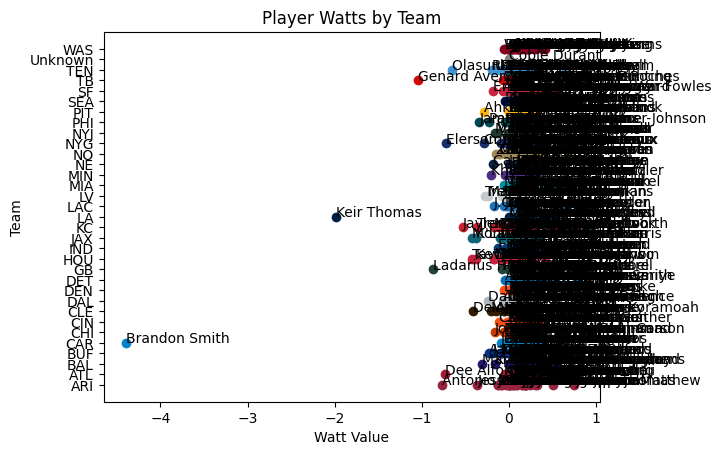

In [404]:
top_10_players_by_position = {}

for position, players_watts in position_watts.items():r
    sorted_players = sorted(players_watts, key=lambda x: x[1], reverse=True)
    top_10_players_by_position[position] = sorted_players[:10]

top_10_players_by_position

In [395]:
top_10_team_watts = sorted(avg_team_watts.items(), key=lambda x: x[1], reverse=True)[:10]

[('SEA', 1.9172460794295225), ('LA', 1.8119613933954517), ('NYJ', 1.7988346309116283), ('DET', 1.5605247520947725), ('IND', 1.5375908065242663), ('MIA', 1.5338806157640816), ('CAR', 1.515152359128469), ('NO', 1.4700903650596637), ('NE', 1.4567381787477054), ('TB', 1.4461898484043716)]


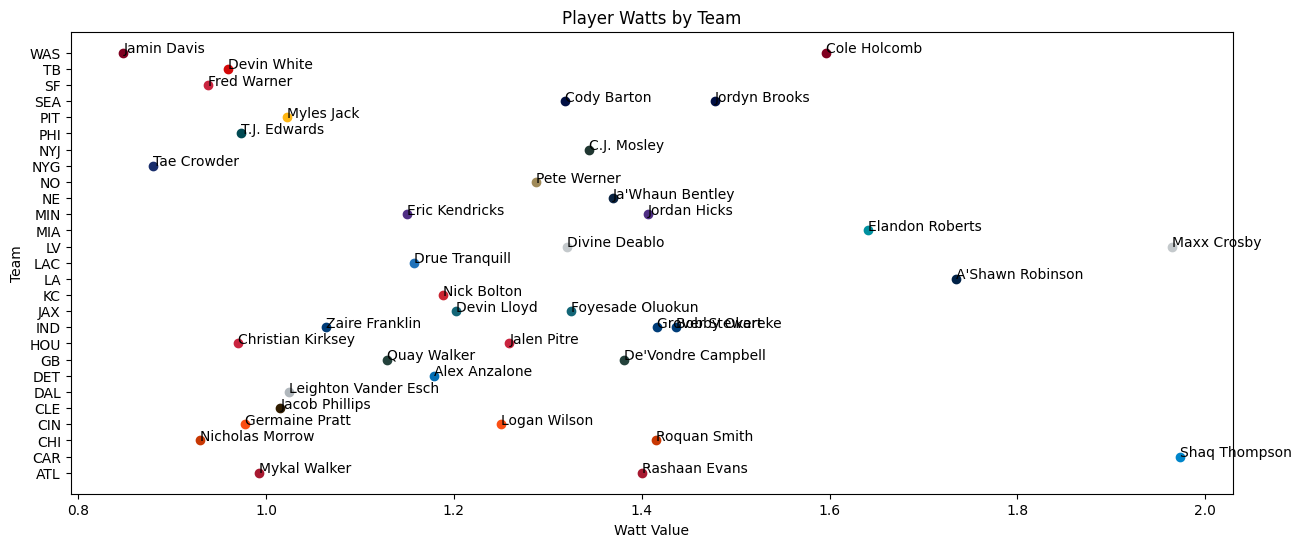

In [381]:

team_colors = []
teams = []
watts = []
names = []
for id, avg_watt in player_watts.items():
    matching_clubs = valid_players[valid_players['nflId'] == id]['club']
    watts.append(avg_watt)
    name = players[players['nflId'] == id]['displayName'].iloc[0]
    names.append(name)
    if not matching_clubs.empty:
        team = matching_clubs.iloc[0]
        teams.append(team)
        team_watts[team]
        team_colors.append(colorway.get(team, '#808080'))  # Get the team color or default to neutral gray
    else:
        teams.append('Unknown')
        team_colors.append('#808080') 

team_categories = pd.Categorical(teams)
team_codes = team_categories.codes

fig, ax = plt.subplots(figsize=(15,6))

for name, watt, team_code, color in zip(names, watts, team_codes, team_colors):
    ax.scatter(watt, team_code, label=name, color=color)
    ax.text(watt, team_code, name)

ax.set_yticks(np.arange(len(np.unique(teams))))
ax.set_yticklabels(np.unique(teams))
ax.set_xlabel('Watt Value')
ax.set_ylabel('Team')
ax.set_title('Player Watts by Team')

plt.show()

46077.0 0.8666931348617241
44888.0 0.7393520295054031
41243.0 0.8724464038553852
43404.0 0.8502385109701487
47788.0 0.7322744648392242
47913.0 0.7443166745731671
47872.0 0.9024813313577347
54492.0 0.5537763025786574
46304.0 0.6927922673571794
46091.0 0.9807933496931466
47855.0 0.6730264240544185
46269.0 0.8648202966332196
52435.0 0.8579930254210517


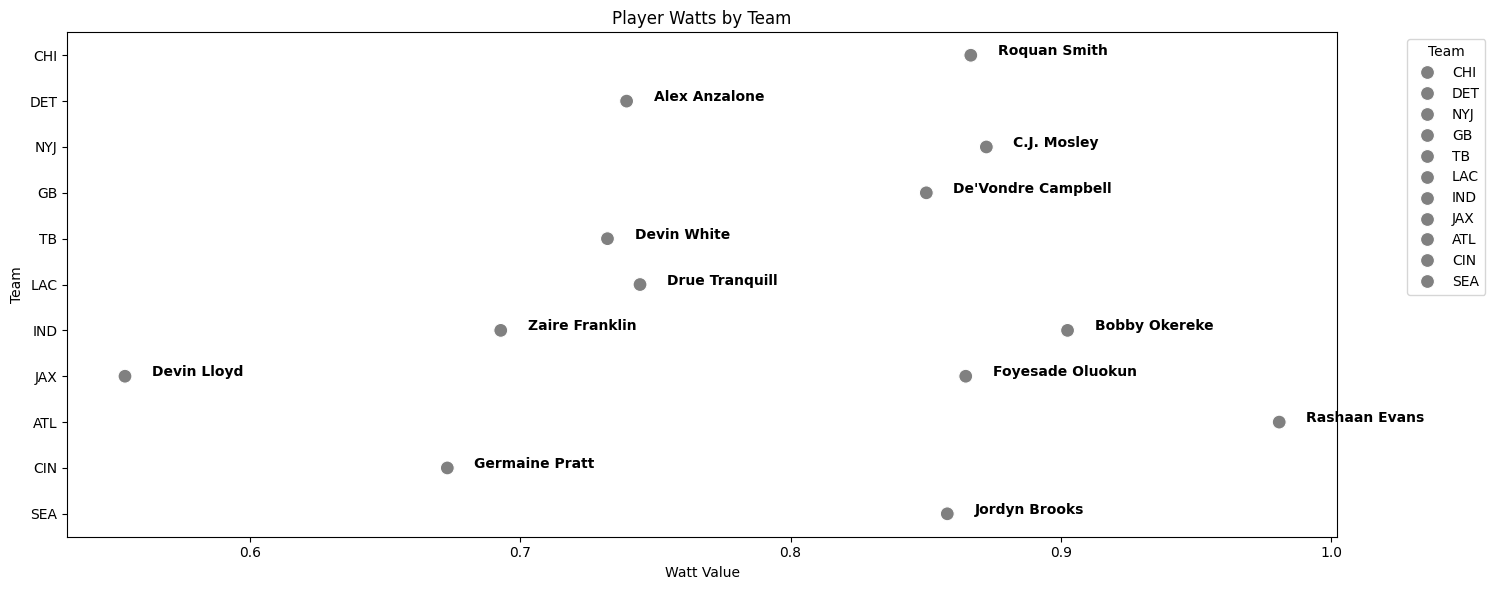

,Name,Watt
9,Rashaan Evans,0.980793
6,Bobby Okereke,0.902481
2,C.J. Mosley,0.872446
0,Roquan Smith,0.866693
11,Foyesade Oluokun,0.864820


In [362]:

# Lists to store data for plotting
team_colors = []
teams = []
watts = []
names = []

# Populate lists with data
for id, avg_watt in player_watts.items():
    print(id, avg_watt)
    matching_clubs = valid_players[valid_players['nflId'] == id]['club']
    watts.append(avg_watt)
    names.append(players[players['nflId'] == id]['displayName'].iloc[0])
    if not matching_clubs.empty:
        team = matching_clubs.iloc[0]
        teams.append(team)
        team_colors.append(colorway.get(team, '#808080'))  # Get the team color or default to neutral gray
    else:
        teams.append('Unknown')
        team_colors.append('#808080')

# Create a DataFrame for seaborn
df = pd.DataFrame({
    'Name': names,
    'Watt': watts,
    'Team': teams,
    'Color': team_colors
})
# Sort to find the top 5 players by 'Watt'
top_5_df = df.sort_values(by='Watt', ascending=False).head(5)

# Create the seaborn scatter plot
plt.figure(figsize=(15, 6))
ax = sns.scatterplot(x='Watt', y='Team', data=df, hue='Team', palette=dict(zip(teams, team_colors)), s=100)

# Add player names to the plot
for line in range(0, df.shape[0]):
     ax.text(df.Watt.iloc[line] + 0.01, df.Team.iloc[line], df.Name.iloc[line], 
             horizontalalignment='left', size='medium', color='black', weight='semibold')

# Set the labels and title
ax.set_xlabel('Watt Value')
ax.set_ylabel('Team')
ax.set_title('Player Watts by Team')
plt.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.tight_layout()
plt.show()

# Code to be executed on the user's end to display the table for the top 5 'Watt' values
top_5_df[['Name', 'Watt']]

In [363]:
colorway = {'ARI':'#97233F','ATL':'#A71930','BAL':'#241773','BUF':'#00338D','CAR':'#0085CA','CHI':'#C83803',
          'CIN':'#FB4F14','CLE':'#311D00','DAL':'#B0B7BC','DEN':'#FB4F14','DET':'#046EB4','GB':'#24423C',
          'HOU':'#C9243F','IND':'#003D79','JAX':'#136677','KC':'#CA2430','LA':'#002147','LAC':'#2072BA',
          'LV':'#C4C9CC','MIA':'#0091A0','MIN':'#4F2E84','NE':'#0A2342','NO':'#A08A58','NYG':'#192E6C',
          'NYJ':'#203731','PHI':'#014A53','PIT':'#FFB612','SEA':'#000F44','SF':'#C9243F','TB':'#D40909',
          'TEN':'#4095D1','WAS':'#800020'}

In [453]:
nflid_chasedowns  = {}
position_chasedowns  = {
    "DE" :  [],
    "SS" :  [],
    "FS" :  [],
    "OLB" : [],
    "DT" :  [],
    "CB" :  [],
    "MLB" : [] }

def chaseDownEfficiency(frames, dists):
    #get integral
    decreasing = True
    integral = 0
    window_x = 0
    x_data = np.array(frames)
    y_data = np.array(dists)
    for idx in range(1, len(x_data)):
        #distance starts increasing
        if (y_data[idx] > y_data[idx - 1]) and (decreasing == True):
            indices = (x_data >= window_x + x_data[0]) & (x_data <= idx + x_data[0])
            x_subset = x_data[indices]
            y_subset = y_data[indices]
            factor = abs(y_subset[0] - y_subset[-1]) / len(x_subset) #better weight for big distance covered in less time
            integral += simps(y_subset, x_subset) * factor
            window_x = idx
            decreasing = False
        #distance starts decreasing, 
        elif (y_data[idx] <= y_data[idx - 1]) and (decreasing == False):
            indices = (x_data >= window_x + x_data[0]) & (x_data <= idx + x_data[0])
            x_subset = x_data[indices]
            y_subset = y_data[indices]
            factor = abs(y_subset[0] - y_subset[-1]) / len(x_subset)
            integral -= simps(y_subset, x_subset) * (factor)
            window_x = idx
            decreasing = True
    #for last section
    indices = (x_data >= window_x + x_data[0]) & (x_data <= x_data[-1])
    x_subset = x_data[indices]
    y_subset = y_data[indices]
    factor = abs(y_subset[0] - y_subset[-1]) / len(x_subset)
    integral += (simps(y_subset, x_subset) * factor) if decreasing else -(simps(y_subset, x_subset) * factor)
    #get chasedown efficiency
    return integral

for game_id, play_id, start_frame, def_club in play_nums:

    curr_play = valid_players[(valid_players['gameId'] == game_id) & (valid_players['playId'] == play_id)]
    curr_play_def = curr_play[curr_play['club'] == def_club]
    ball_carrier_id = plays[(plays['gameId'] == game_id) & (plays['playId'] == play_id)]['ballCarrierId'].iloc[0]
    ball_carrier_data = curr_play[curr_play['nflId'] == ball_carrier_id]
    for defender_id in curr_play_def['nflId'].unique():
        defender_id_data = curr_play_def[curr_play_def['nflId'] == defender_id]
        position = players[players['nflId'] == defender_id]['position'].iloc[0]
        distances = np.sqrt((defender_id_data['x'].values - ball_carrier_data['x'].values)**2 +
                            (defender_id_data['y'].values - ball_carrier_data['y'].values)**2)
        
        # # Plotting distance over frames
        # plt.plot(defender_id_data['frameId'], distances, label=f'Defender_id {defender_id}')
        
        if position in position_chasedowns.keys():
            chaseDown = chaseDownEfficiency(defender_id_data['frameId'], distances)
            if defender_id in nflid_chasedowns:
                new_sum = nflid_chasedowns[defender_id][0] + chaseDown
                new_total = 1 + nflid_chasedowns[defender_id][1]
                nflid_chasedowns[defender_id] = (new_sum, new_total, def_club)
            else:
                nflid_chasedowns[defender_id] = (chaseDown, 1, def_club)


        # plt.xlabel('Frame')
        # plt.ylabel('Distance to Ball Carrier')
        # plt.title(f'Distance from Defender_id {defender_id} to the Ball Carrier Over Time, Play: {game_id} {play_id}')
        # plt.legend()
        # plt.show()
    


In [456]:
average_chasedowns = {}
for nfl_id, (aggregate_chasedown, num_chasedowns, team) in nflid_chasedowns.items():
    if num_chasedowns >=25:
        name, position = players[players['nflId'] == nfl_id]['displayName'].iloc[0], players[players['nflId'] == nfl_id]['position'].iloc[0]
        avg_chasedown = aggregate_chasedown / num_chasedowns
        average_chasedowns[nfl_id] = avg_chasedown
        position_chasedowns[position].append((name, avg_chasedown, team))


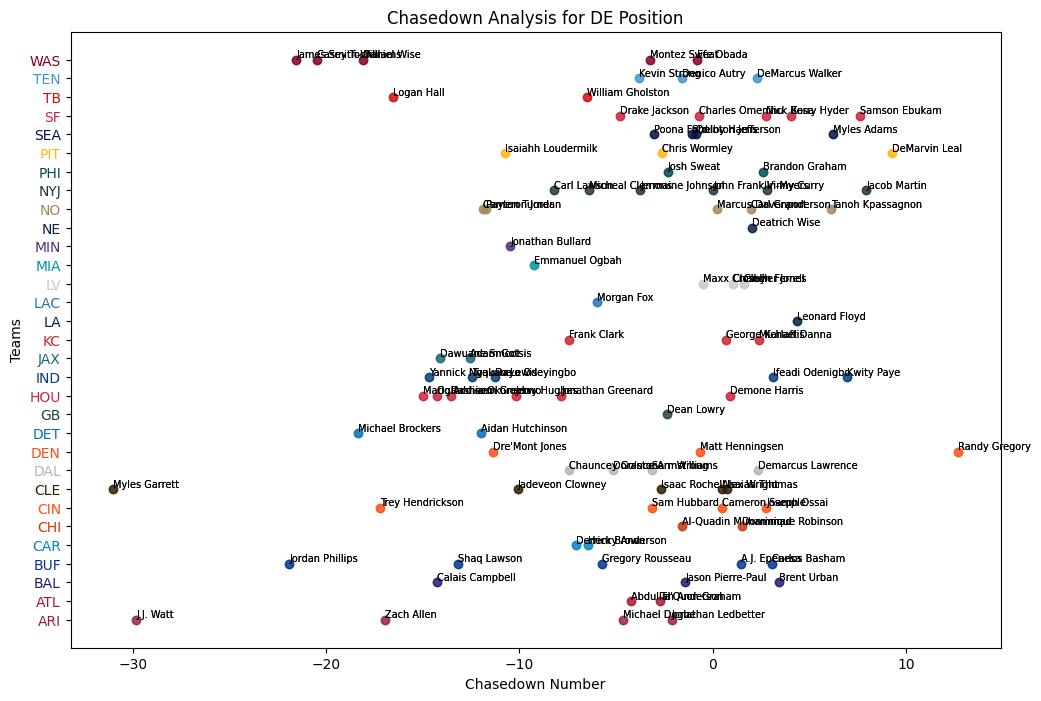

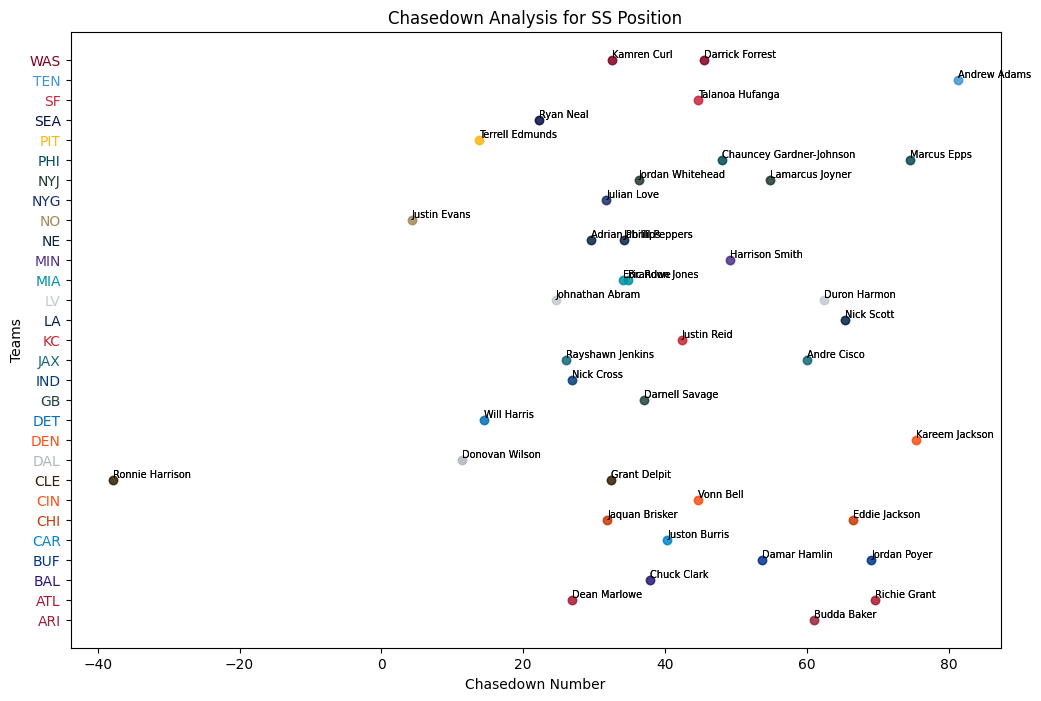

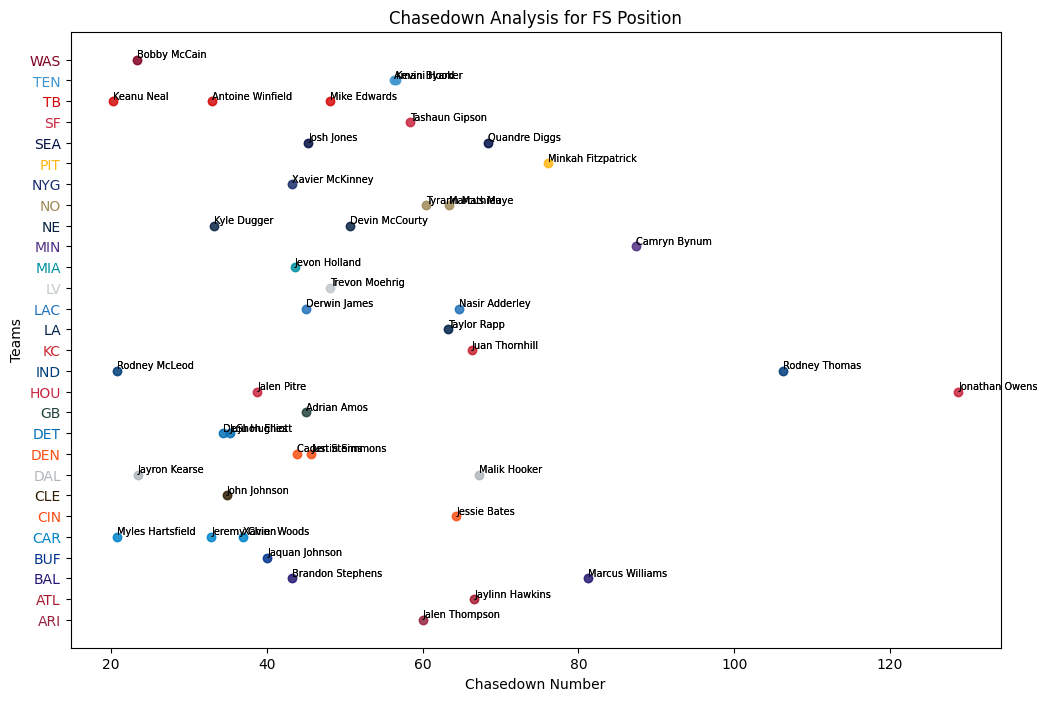

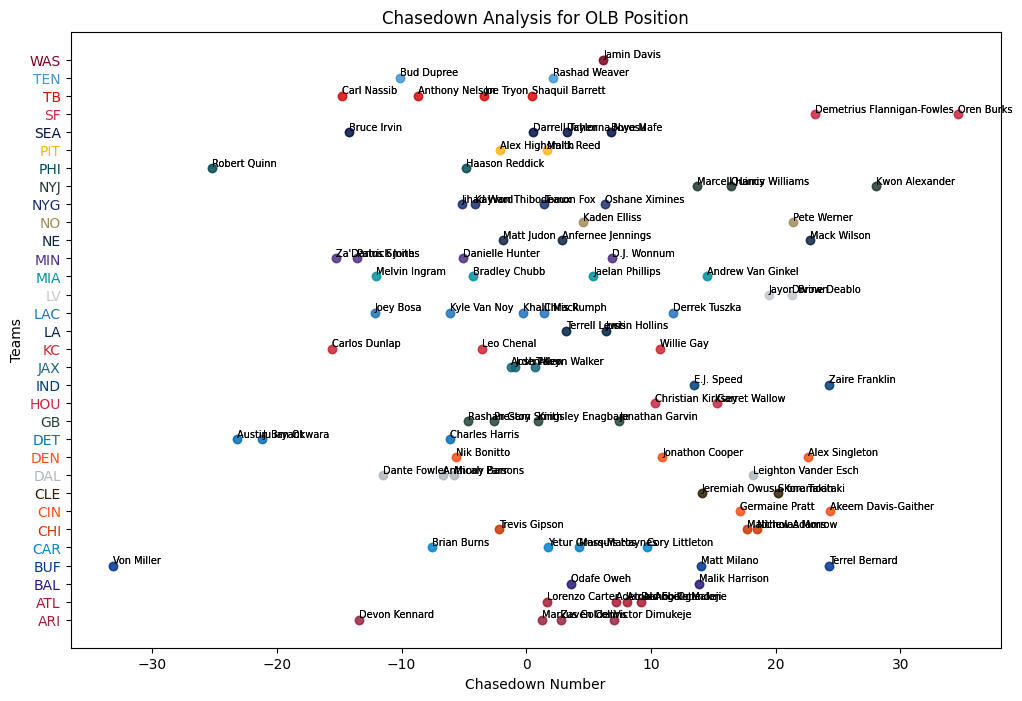

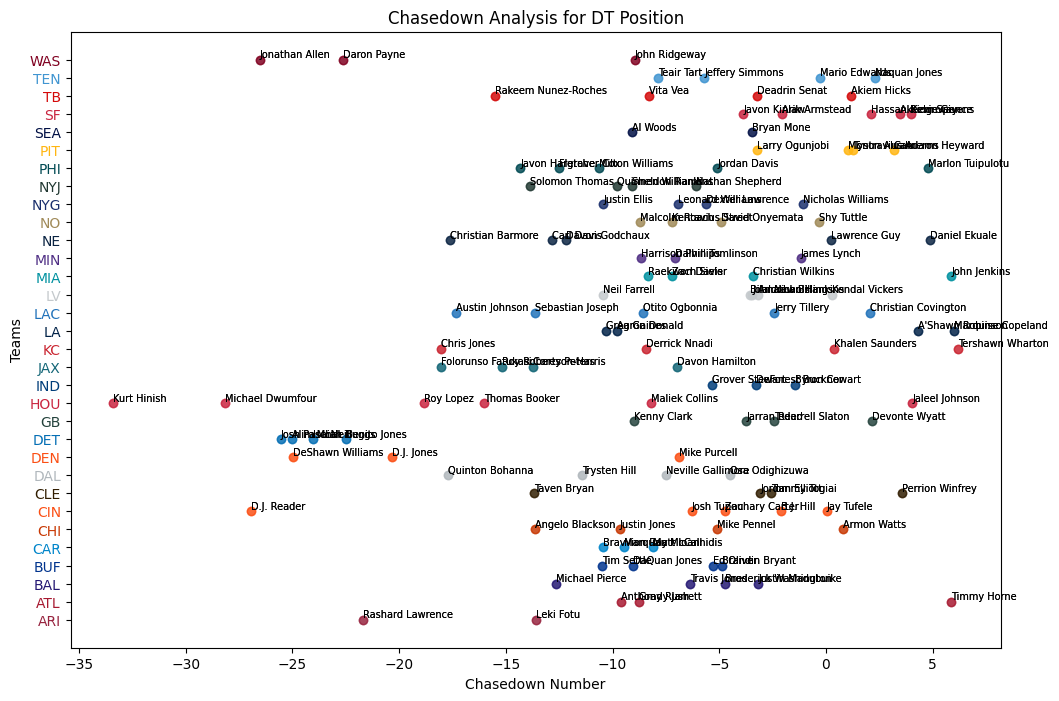

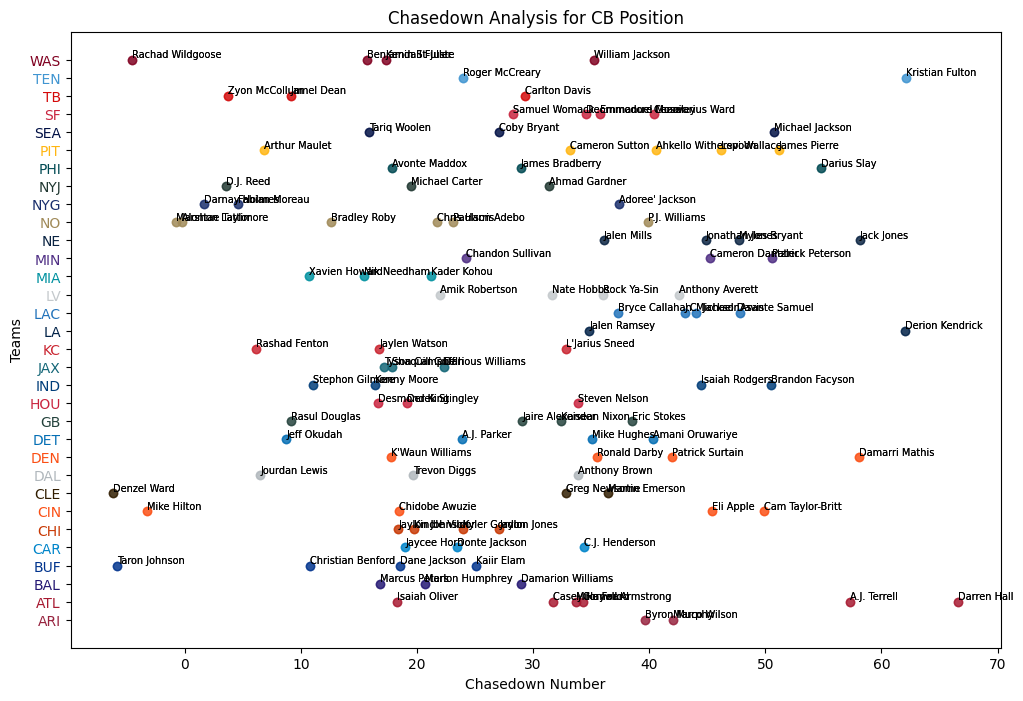

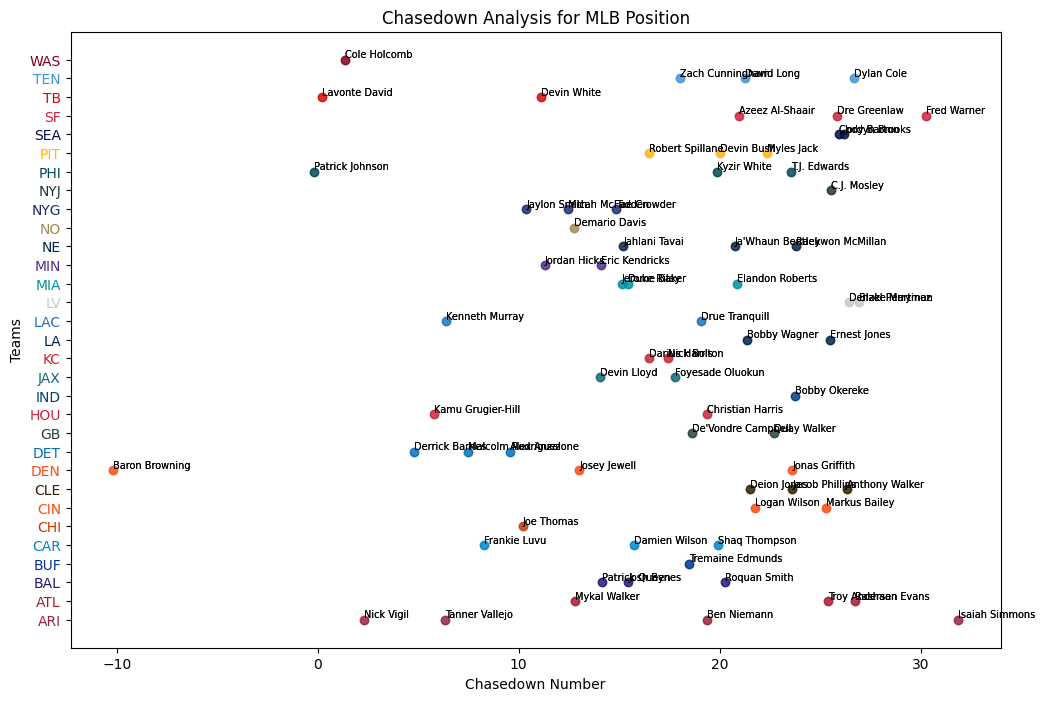

In [458]:
top_10_chasedown_positions = {
    "DE" :  [],
    "SS" :  [],
    "FS" :  [],
    "OLB" : [],
    "DT" :  [],
    "CB" :  [],
    "MLB" : [] }
for position, players_chasedowns in position_chasedowns.items():
    plt.figure(figsize=(12,8), dpi=100)

    # Lists for storing plot data
    chasedown_values = []
    teams = []
    player_names = []

    #for top 5
    top_10_chasedown_positions[position] = sorted(players_chasedowns, key=lambda x: x[1], reverse=True)[:10]

    # Extracting data for the current position
    for name, chasedown, team in players_chasedowns:
        chasedown_values.append(chasedown)
        teams.append(team)
        player_names.append(name)
    # Convert team names to categorical types for plotting
    teams_categorical = pd.Categorical(teams)
    team_codes = teams_categorical.codes

    # Creating a scatter plot
    for chasedown, team_code, team, name in zip(chasedown_values, team_codes, teams, player_names):
        color = colorway.get(team, 'grey')  # Default color if team not in map
        plt.scatter(chasedown, team_code, color=color, alpha=0.6)
        plt.text(chasedown, team_code, name, fontsize=7, ha='left', va = 'bottom')
    # Setting y-axis with team names and corresponding colors
    plt.yticks(range(len(teams_categorical.categories)), teams_categorical.categories)
    for i, label in enumerate(plt.gca().get_yticklabels()):
        team_name = label.get_text()
        label.set_color(colorway.get(team_name, 'black'))

    # Setting labels and title
    plt.xlabel('Chasedown Number')
    plt.ylabel('Teams')
    plt.title(f'Chasedown Analysis for {position} Position')

    # Show plot
    plt.show()

In [ ]:
#getting best teams SPEED for lineman, linebackers, secondary

# Grouping positions
position_groups = {
    'D-line': ['DE', 'DT'],
    'Linebackers': ['OLB', 'MLB'],
    'Secondary': ['SS', 'FS', 'CB']
}

# Initialize a dictionary to store team SPEED
team_efficiency = {
    'D-line': {}, #initially stores a dict from team -> dict {chase_down sum, player_count}
    'Linebackers': {}, #then stores the avg_chasedown for that position group 
    'Secondary': {}
}

top_5_defensive_lines = []
top_5_linebackers = []
top_5_secondaries = []

# Calculate average SPEED
for group, positions in position_groups.items():
    for position in positions:
        for name, chasedown, team in position_chasedowns[position]:
            if team not in team_efficiency[group]:
                team_efficiency[group][team] = {'total_chasedowns': 0, 'player_count': 0}
            team_efficiency[group][team]['total_chasedowns'] += chasedown
            team_efficiency[group][team]['player_count'] += 1

    # Calculate average and sort teams
    for team in team_efficiency[group]:
        total_chasedowns = team_efficiency[group][team]['total_chasedowns']
        player_count = team_efficiency[group][team]['player_count']
        team_efficiency[group][team] = total_chasedowns / player_count if player_count else 0

# Sort teams by SPEED
top_5_defensive_lines = [team for team, value in (sorted(team_efficiency['D-line'].items(), key=lambda x: x[1], reverse=True)[:5])]
top_5_linebackers = [team for team, value in (sorted(team_efficiency['Linebackers'].items(), key=lambda x: x[1], reverse=True)[:5])]
top_5_secondaries = [team for team, value in (sorted(team_efficiency['Secondary'].items(), key=lambda x: x[1], reverse=True)[:5])]
print(top_5_defensive_lines)
print(top_5_linebackers)
print(top_5_secondaries)



['SF', 'PIT', 'LA', 'SEA', 'TEN']
['SF', 'LV', 'CIN', 'CLE', 'NYJ']
['LA', 'TEN', 'MIN', 'ARI', 'HOU']


In [ ]:
TeamMissedTackles = {}
keys = team_efficiency['Linebackers']
TeamMissedTackles = dict.fromkeys(keys, 0)

missed_tackles_by_play = missed_tackles.groupby(['gameId', 'playId'])['pff_missedTackle'].sum().reset_index()
for index, row in missed_tackles_by_play.iterrows():
    game_id, play_id, missed_tackles = row['gameId'], row['playId'], row['pff_missedTackle']
    defensive_team = plays[(plays['gameId'] == game_id) & (plays['playId'] == play_id)]['defensiveTeam'].iloc[0]
    TeamMissedTackles[defensive_team] += missed_tackles

sorted_values = sorted(TeamMissedTackles. items(), key=lambda x: x[1],  reverse = True)
top_10_values = sorted_values[:10]


<class 'pandas.core.frame.DataFrame'>
[('JAX', 98), ('HOU', 90), ('ATL', 80), ('CAR', 79), ('LV', 79), ('MIA', 78), ('DEN', 76), ('CHI', 75), ('PHI', 74), ('BUF', 73)]


106 106


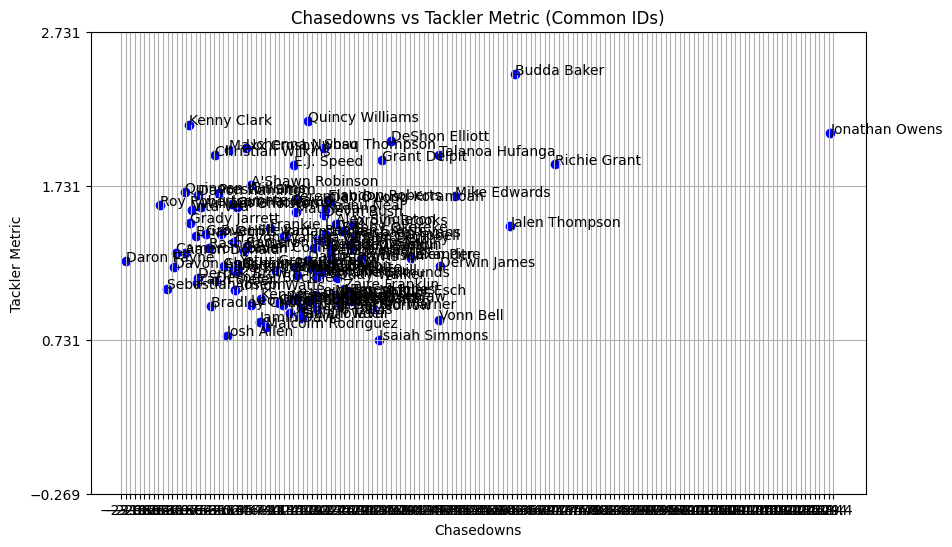

In [445]:
# Filtering IDs that are present in both dictionaries
common_ids = [id for id in average_chasedowns if id in player_watts]
# Extracting data for plotting for the common IDs
chasedowns_common = [average_chasedowns[id] for id in common_ids]
tackler_metrics_common = [player_watts[id] for id in common_ids]

# Creating the plot for the common IDs
plt.figure(figsize=(10, 6))
plt.scatter(chasedowns_common, tackler_metrics_common, color='blue')
plt.title('Chasedowns vs Tackler Metric (Common IDs)')
plt.xlabel('Chasedowns')
plt.ylabel('Tackler Metric')
plt.grid(True)
plt.xticks(np.arange(min(chasedowns_common)-1, max(chasedowns_common)+1, 1.0))
plt.yticks(np.arange(min(tackler_metrics_common)-1, max(tackler_metrics_common)+1, 1.0))

# Annotating each point with its ID
for i, id in enumerate(common_ids):
    plt.annotate(players[players['nflId'] == id]['displayName'].iloc[0], (chasedowns_common[i], tackler_metrics_common[i]))

plt.show()


In [449]:
df = pd.DataFrame(list(player_watts.items()), columns=['ID', 'Value'])
df.to_csv('avg_watt.csv', index=False) 

In [450]:
df = pd.DataFrame(list(average_chasedowns.items()), columns=['ID', 'Value'])
df.to_csv('avg_speed.csv', index=False) 

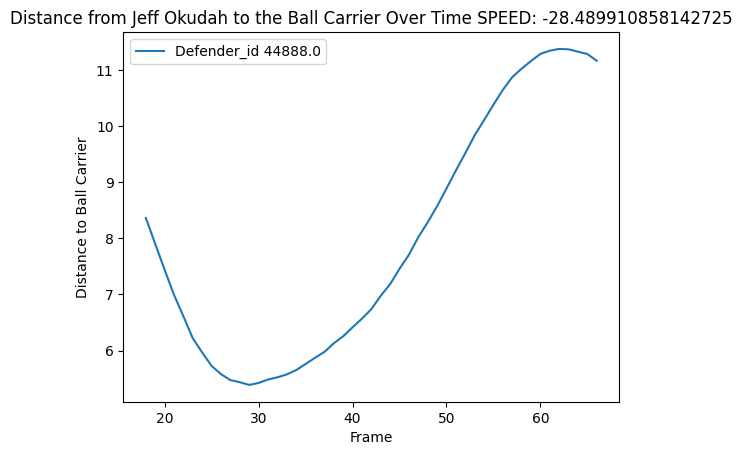

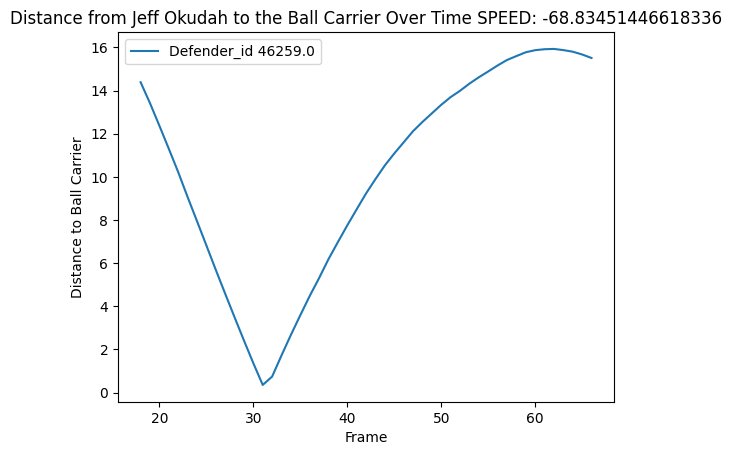

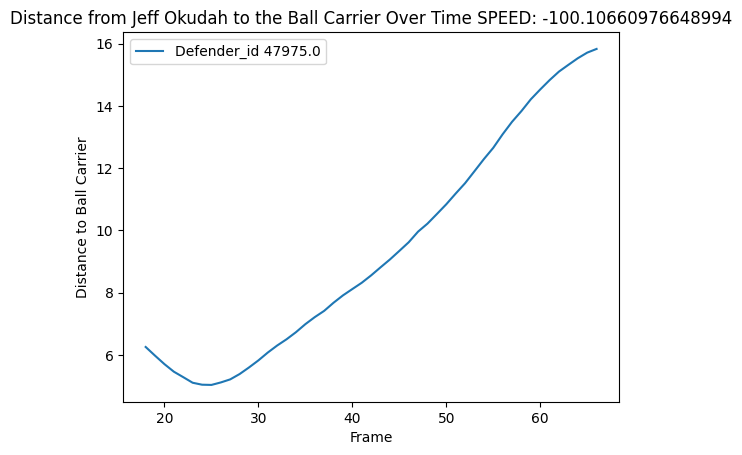

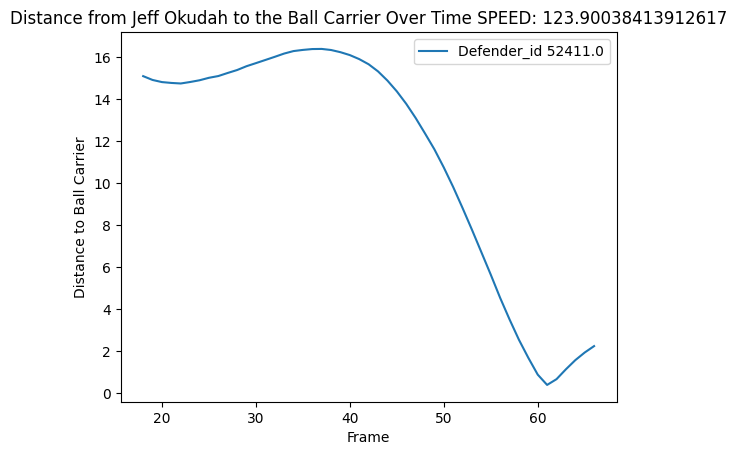

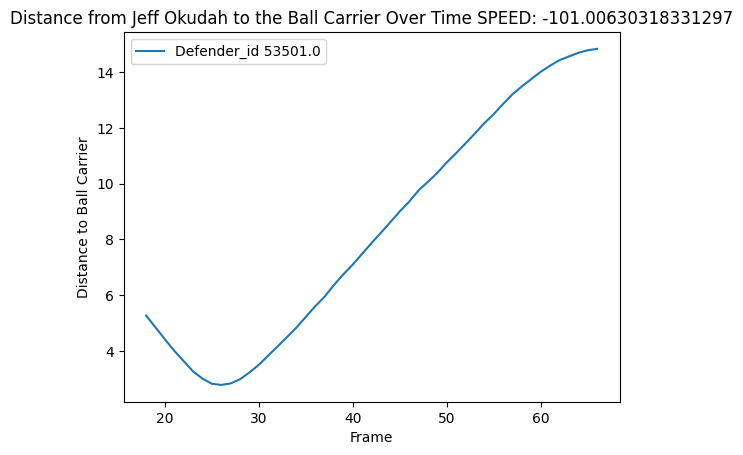

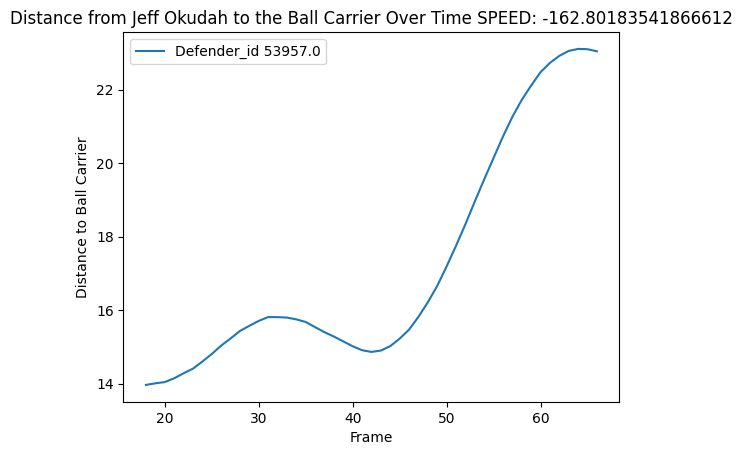

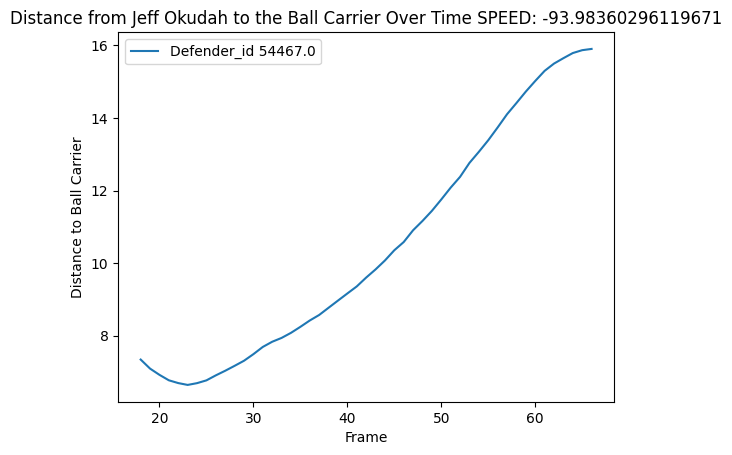

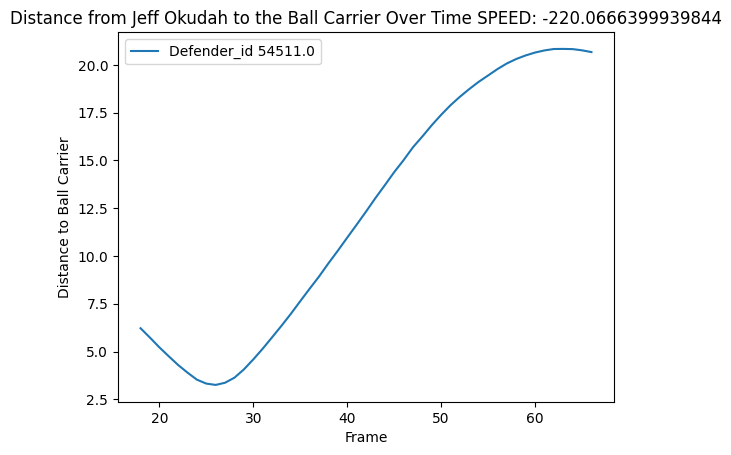

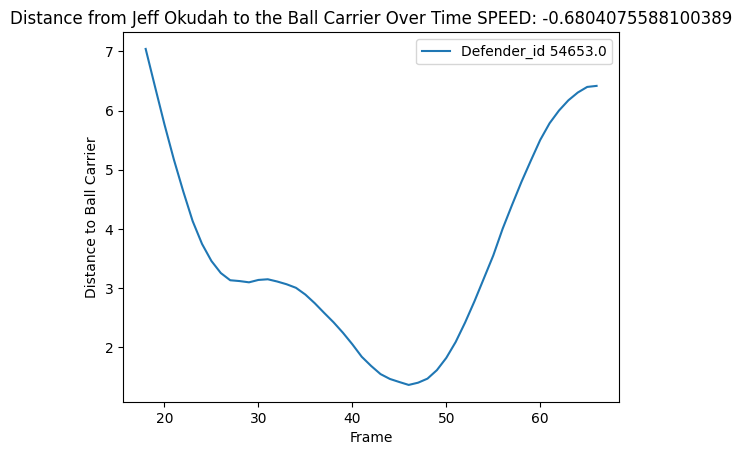

In [451]:
position_chasedowns  = {
    "DE" :  [],
    "SS" :  [],
    "FS" :  [],
    "OLB" : [],
    "DT" :  [],
    "CB" :  [],
    "MLB" : [] }

def getSPEED(frames, dists):
    #get integral
    decreasing = True
    integral = 0
    window_x = 0
    x_data = np.array(frames)
    y_data = np.array(dists)
    for idx in range(1, len(x_data)):
        #distance starts increasing
        if (y_data[idx] > y_data[idx - 1]) and (decreasing == True):
            indices = (x_data >= window_x + x_data[0]) & (x_data <= idx + x_data[0])
            x_subset = x_data[indices]
            y_subset = y_data[indices]
            factor = abs(y_subset[0] - y_subset[-1]) / len(x_subset) #better weight for big distance covered in less time
            integral += simps(y_subset, x_subset) * factor
            window_x = idx
            decreasing = False
        #distance starts decreasing, 
        elif (y_data[idx] <= y_data[idx - 1]) and (decreasing == False):
            indices = (x_data >= window_x + x_data[0]) & (x_data <= idx + x_data[0])
            x_subset = x_data[indices]
            y_subset = y_data[indices]
            factor = abs(y_subset[0] - y_subset[-1]) / len(x_subset)
            integral -= simps(y_subset, x_subset) * (factor)
            window_x = idx
            decreasing = True
    #for last section
    indices = (x_data >= window_x + x_data[0]) & (x_data <= x_data[-1])
    x_subset = x_data[indices]
    y_subset = y_data[indices]
    factor = abs(y_subset[0] - y_subset[-1]) / len(x_subset)
    integral += (simps(y_subset, x_subset) * factor) if decreasing else -(simps(y_subset, x_subset) * factor)
    #get SPEED
    return integral

for game_id, play_id, start_frame, def_club in play_nums:
    curr_play = valid_players[(valid_players['gameId'] == game_id) & (valid_players['playId'] == play_id)]
    curr_play_def = curr_play[curr_play['club'] == def_club]
    ball_carrier_id = plays[(plays['gameId'] == game_id) & (plays['playId'] == play_id)]['ballCarrierId'].iloc[0]
    ball_carrier_data = curr_play[curr_play['nflId'] == ball_carrier_id]
    for defender_id in curr_play_def['nflId'].unique():
        defender_id_data = curr_play_def[curr_play_def['nflId'] == defender_id]
        position = players[players['nflId'] == defender_id]['position'].iloc[0]
        distances = np.sqrt((defender_id_data['x'].values - ball_carrier_data['x'].values)**2 +
                            (defender_id_data['y'].values - ball_carrier_data['y'].values)**2)
        
        # # Plotting distance over frames
        plt.plot(defender_id_data['frameId'], distances, label=f'Defender_id {defender_id}')
        
        if position in position_chasedowns.keys():
            chaseDown = getSPEED(defender_id_data['frameId'], distances)
            if defender_id in nflid_chasedowns:
                new_sum = nflid_chasedowns[defender_id][0] + chaseDown
                new_total = 1 + nflid_chasedowns[defender_id][1]

        plt.xlabel('Frame')
        plt.ylabel('Distance to Ball Carrier')
        plt.title(f' GameId/PlayId : {(game_id, play_id)}Distance from Defender to the Ball Carrier Over Time SPEED: {chaseDown}')
        plt.legend()
        plt.show()